# Phase 2: The Text Pipeline
## 1. Objectives
**Goal:** Convert unstructured text (Reviews) into numerical features that can drive our occupancy model.

**Steps:**
1.  **Filter:** Keep only "substantial" reviews (> 40 words).
2.  **Clean:** Remove HTML, punctuation, and stop words.
3.  **Sentiment Analysis:** Use VADER to score reviews (-1 to +1).
4.  **Topic Modeling:** Use LDA to discover hidden themes (e.g., "Noise", "Location").
5.  **Text Classification:** Train a Logistic Regression model to validate that text *predicts* sentiment.

In [1]:
import pandas as pd
import numpy as np
import re
import sys
import os

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Add parent directory for config
sys.path.append('..')
import config

# Download necessary NLTK data (run once)
nltk.download('stopwords')
nltk.download('wordnet')

print(f"✅ Setup Complete. Data Path: {config.DATA_RAW}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prajw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prajw\AppData\Roaming\nltk_data...


✅ Setup Complete. Data Path: C:\Users\prajw\MSCDAD_B2025\Data Mining and Machine Learning\Amsterdam_Forecast\data\raw


[nltk_data]   Package wordnet is already up-to-date!


## 2. Load & Filter Data
We load the raw reviews.
**Constraint Check:** We calculate the word count for every review and **drop** any review with fewer than 40 words. This ensures we analyze meaningful content, not just "Great place!"

In [2]:
# 1. Load Reviews
print("⏳ Loading Reviews Data...")
df_reviews = pd.read_csv(config.REVIEWS_FILE)

# Fill NaN comments to avoid errors
df_reviews['comments'] = df_reviews['comments'].fillna('')

# 2. Calculate Word Count
# We split by whitespace to count words
df_reviews['word_count'] = df_reviews['comments'].apply(lambda x: len(str(x).split()))

# 3. Apply Constraint (Word Count >= 40)
initial_count = len(df_reviews)
df_reviews = df_reviews[df_reviews['word_count'] >= 40].copy()
final_count = len(df_reviews)

print(f"📉 Filter Applied: {initial_count} -> {final_count} reviews kept.")
print(f"   (Dropped {initial_count - final_count} short reviews)")

df_reviews.head(3)

⏳ Loading Reviews Data...
📉 Filter Applied: 501084 -> 208304 reviews kept.
   (Dropped 292780 short reviews)


,listing_id,id,date,reviewer_id,reviewer_name,comments,word_count
2,839610,47062612,2015-09-15,25521258,Scott,"Michael, Jacob's son was the one to coordinate...",68
5,839610,65253023,2016-03-12,15017175,Sergei,We made a business trip in Amsterdam. This apa...,53
8,839610,210242042,2017-11-08,145039581,Susel Estefania,El departamento es muy bonito y espacioso. Par...,58


## 3. Text Cleaning
Standard NLP preprocessing:
1.  **Lowercase**: "Nice" -> "nice"
2.  **Regex**: Remove HTML tags (`<br/>`) and punctuation.
3.  **Stop Words**: Remove common words ("the", "is", "and") that add noise but no meaning.

In [3]:
# Load Stop Words
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # 1. Lowercase
    text = str(text).lower()
    
    # 2. Remove HTML tags (e.g., <br/>)
    text = re.sub(r'<.*?>', '', text)
    
    # 3. Remove Punctuation & Special Chars (Keep only a-z)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 4. Remove Stop Words
    words = text.split()
    words = [w for w in words if w not in stop_words]
    
    return " ".join(words)

print("⏳ Cleaning text... (This takes time for large datasets)")
df_reviews['clean_comments'] = df_reviews['comments'].apply(clean_text)

print("✅ Text Cleaned.")
df_reviews[['comments', 'clean_comments']].head(3)

⏳ Cleaning text... (This takes time for large datasets)
✅ Text Cleaned.


,comments,clean_comments
2,"Michael, Jacob's son was the one to coordinate...",michael jacobs son one coordinate greet us abs...
5,We made a business trip in Amsterdam. This apa...,made business trip amsterdam apartments good t...
8,El departamento es muy bonito y espacioso. Par...,el departamento es muy bonito espacioso parece...


## 4. Feature Engineering: Sentiment Analysis
We use **VADER (Valence Aware Dictionary and sEntiment Reasoner)**.
It gives a compound score from **-1 (Most Negative)** to **+1 (Most Positive)**.

In [4]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

print("⏳ Calculating Sentiment Scores...")
df_reviews['sentiment_score'] = df_reviews['clean_comments'].apply(get_sentiment)

# Create a Binary Label for our Classification Task
# > 0.5 is Positive, <= 0.5 is Negative/Neutral (Strict threshold)
df_reviews['sentiment_label'] = (df_reviews['sentiment_score'] > 0.5).astype(int)

print("✅ Sentiment Calculated.")
df_reviews[['clean_comments', 'sentiment_score', 'sentiment_label']].head()

⏳ Calculating Sentiment Scores...
✅ Sentiment Calculated.


,clean_comments,sentiment_score,sentiment_label
2,michael jacobs son one coordinate greet us abs...,0.8955,1
5,made business trip amsterdam apartments good t...,0.8271,1
8,el departamento es muy bonito espacioso parece...,0.0000,0
11,lovely apartment mins walk museums jacobs son ...,0.9282,1
16,space great location beautiful quiet street cl...,0.9834,1


## 5. Modeling Task 1: Sentiment Classification (Logistic Regression)
**Goal:** Verify if the words used actually predict the sentiment score.
**Method:** TF-IDF Vectorization -> Logistic Regression.

In [5]:
# 1. Vectorize (Top 1000 words only to keep it fast)
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df_reviews['clean_comments'])
y = df_reviews['sentiment_label']

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=config.SEED)

# 3. Train
model_lr = LogisticRegression(random_state=config.SEED)
model_lr.fit(X_train, y_train)

# 4. Evaluate
print("📊 Logistic Regression Performance (Text -> Sentiment):")
print(classification_report(y_test, model_lr.predict(X_test)))

📊 Logistic Regression Performance (Text -> Sentiment):
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      8210
           1       0.98      0.98      0.98     33451

    accuracy                           0.97     41661
   macro avg       0.96      0.96      0.96     41661
weighted avg       0.97      0.97      0.97     41661



## 6. Modeling Task 2: Topic Modeling (LDA)
**Goal:** Discover hidden themes (Latent Dirichlet Allocation).
We look for 3 dominant topics in the Amsterdam reviews.

In [6]:
# 1. Count Vectorizer (LDA requires integer counts, not TF-IDF floats)
tf_vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X_lda = tf_vectorizer.fit_transform(df_reviews['clean_comments'])

# 2. Run LDA (Find 3 Topics)
# Note: n_jobs=-1 uses all CPU cores
print("⏳ Running LDA Topic Modeling...")
lda = LatentDirichletAllocation(n_components=3, random_state=config.SEED, n_jobs=-1)
lda.fit(X_lda)

# 3. Display Topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("\n🔍 Discovered Topics:")
print_top_words(lda, tf_vectorizer.get_feature_names_out(), 10)

# 4. Assign Dominant Topic to each review
topic_values = lda.transform(X_lda)
df_reviews['dominant_topic'] = topic_values.argmax(axis=1)

⏳ Running LDA Topic Modeling...

🔍 Discovered Topics:
Topic #0: stay great place amsterdam apartment location nice clean recommend host
Topic #1: und die sehr ist es der wir la war das
Topic #2: et trs est la le en nous pour bien les


## 7. Save Processed Text Data
We save the enriched reviews. We will aggregate these by `listing_id` in Phase 3.

In [7]:
# Save only what we need for the merger
output_cols = ['listing_id', 'date', 'sentiment_score', 'dominant_topic', 'word_count']
output_path = os.path.join(config.DATA_PROCESSED, '02_text_enriched.csv')

df_reviews[output_cols].to_csv(output_path, index=False)
print(f"💾 Saved Enriched Text Data to: {output_path}")

💾 Saved Enriched Text Data to: C:\Users\prajw\MSCDAD_B2025\Data Mining and Machine Learning\Amsterdam_Forecast\data\processed\02_text_enriched.csv


✅ Saved Topic Plot to: C:\Users\prajw\MSCDAD_B2025\Data Mining and Machine Learning\Amsterdam_Forecast\output\topic_keywords.png


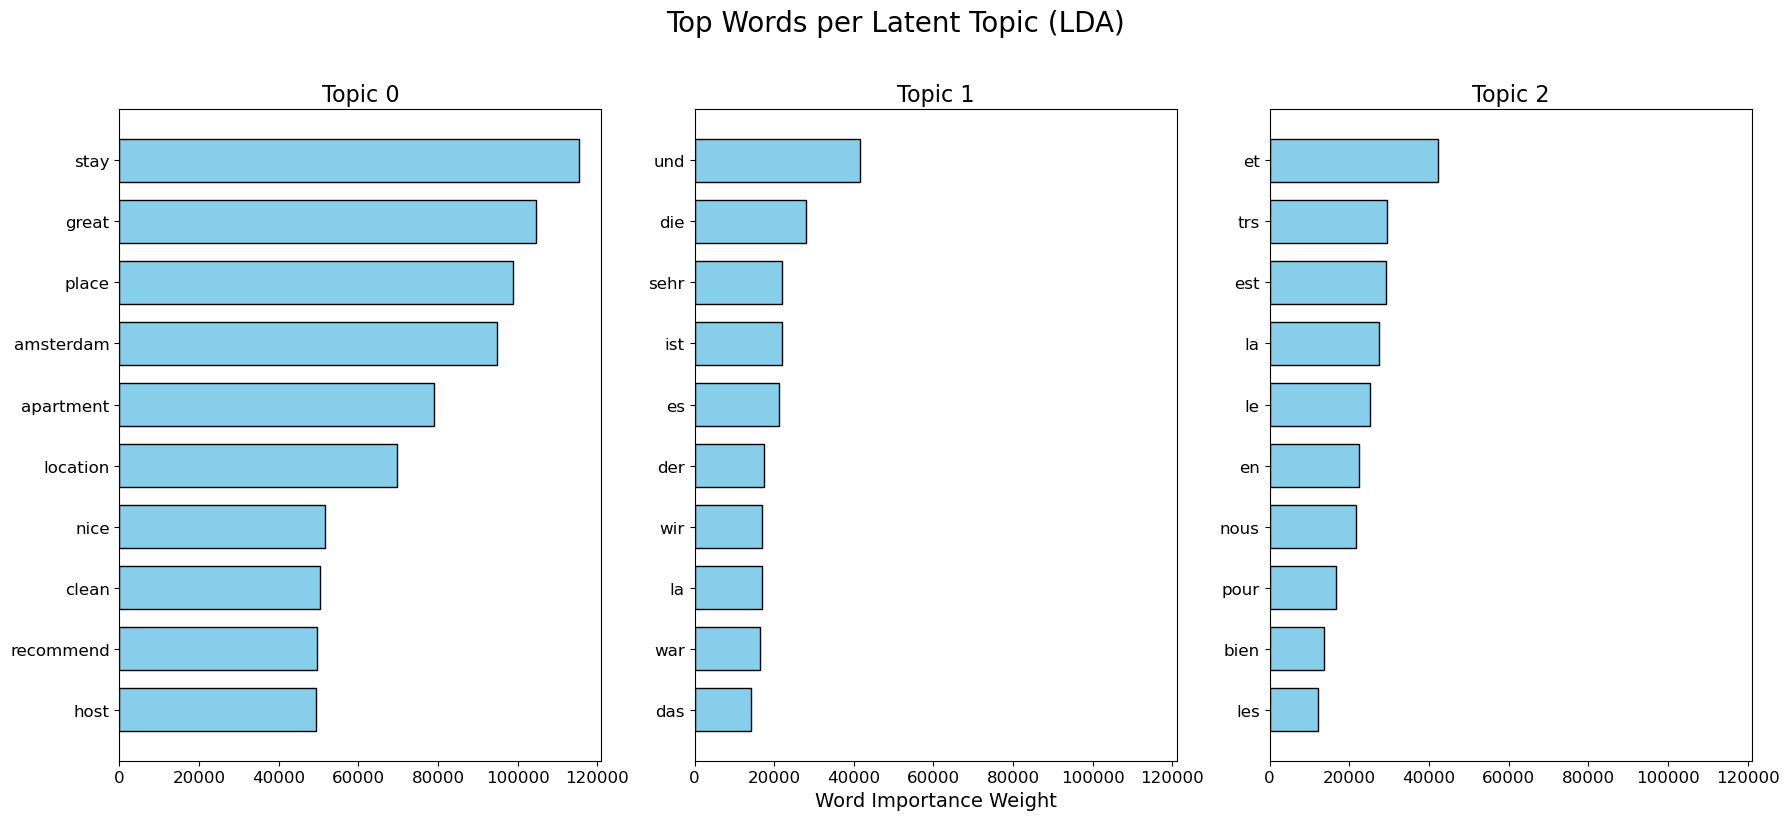

In [8]:
# ---------------------------------------------------------
# VISUALIZATION GENERATOR: Topic Modeling
# ---------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Output setup
output_dir = os.path.join(config.BASE_DIR, 'output')
os.makedirs(output_dir, exist_ok=True)

def plot_top_words(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='skyblue', edgecolor='black')
        ax.set_title(f'Topic {topic_idx}', fontdict={'fontsize': 16})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Add labels to X-axis only for the middle plot
        if topic_idx == 1:
            ax.set_xlabel('Word Importance Weight', fontsize=14)

    plt.suptitle('Top Words per Latent Topic (LDA)', fontsize=20, y=1.02)
    plt.tight_layout()
    
    # Save
    save_path = os.path.join(output_dir, 'topic_keywords.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved Topic Plot to: {save_path}")
    plt.show()

# Run the plotter
plot_top_words(lda, tf_vectorizer.get_feature_names_out())